In [1]:
import numpy as np
import scipy as sp
import scipy.linalg
import cvxpy as cp
import matplotlib.pyplot as plt
import random
import math
import sys

In [2]:
def NKron(*args):
  result = np.array([[1.0]])
  for op in args:
    result = np.kron(result, op)
  return result

In [3]:
Id = np.eye(2)
X = np.array([[0.0, 1.0],[1.0, 0.0]])
Z = np.array([[1.0, 0.0],[0.0, -1.0]])
Y = np.matmul(X,Z)

In [4]:
# NormalizeState = lambda state: state / sp.linalg.norm(state)
def NormalizeState(ipVal):
    if(sp.linalg.norm(ipVal) == 0): return ipVal
    else : return ipVal / sp.linalg.norm(ipVal)
zero = np.array([[1.0], [0.0]]) # |0>
one = np.array([[0.0], [1.0]]) # |1>

## Generators

In [5]:
def NKronModified(checkRowMod):
  result = np.array([[1.0]])
  for ind in checkRowMod:
    if(ind == 0):
        op = Id
    elif(ind == 1):
        op = X
    elif(ind == 2):
        op = Y
    elif(ind == 3):
        op = Z
    result = np.kron(result, op)
  return result

def getGenerator(checkRow):
    checkRowModified = np.zeros(n, dtype=int)
    
    checkRowModified[(checkRow[:n] == checkRow[n:]) & (checkRow[n:] == 1)] = 2
    checkRowModified[(checkRow[:n] == 1) & (checkRowModified != 2)] = 1
    checkRowModified[(checkRow[n:] == 1) & (checkRowModified != 2)] = 3
    
    return NKronModified(checkRowModified)    

In [6]:
comparingAccuracy_decoded = 1e-7
comparingAccuracy_encoded = 1e-5
comparingAccuracy_syndrome = 1e-5
comparingAccuracy_method = 1e-5

In [7]:
Hmatrix = np.array([[1,0,1,0,1,0,1],
                    [0,1,1,0,0,1,1],
                    [0,0,0,1,1,1,1]])

na = Hmatrix.shape[1]
nb = Hmatrix.shape[0]

Hx = np.concatenate((np.kron(np.eye(na), Hmatrix), np.kron(Hmatrix.T, np.eye(nb))), axis=1)
Hz = np.concatenate((np.kron(Hmatrix, np.eye(na)), np.kron(np.eye(nb), Hmatrix.T)), axis=1)

H1 = np.concatenate((Hx, np.zeros([Hx.shape[0], Hx.shape[1]])), axis=1)
H2 = np.concatenate((np.zeros([Hz.shape[0], Hz.shape[1]]), Hz), axis=1)

# checkMatrix = np.concatenate((H1, H2), axis=0)

In [8]:
# change check matrix here

# checkMatrix = np.array([[1,1,1,1,1,1,1,1, 0,0,0,0,0,0,0,0],
#                         [0,0,0,0,0,0,0,0, 1,1,1,1,1,1,1,1],
#                         [0,1,0,1,1,0,1,0, 0,0,0,0,1,1,1,1],
#                         [0,1,0,1,0,1,0,1, 0,0,1,1,0,0,1,1],
#                         [0,1,1,0,1,0,0,1, 0,1,0,1,0,1,0,1]])

# checkMatrix = np.array([[0,0,0,0,0,0,0,0,0, 1,1,0,0,0,0,0,0,0],
#                         [0,0,0,0,0,0,0,0,0, 1,0,1,0,0,0,0,0,0],
#                         [0,0,0,0,0,0,0,0,0, 0,0,0,1,1,0,0,0,0],
#                         [0,0,0,0,0,0,0,0,0, 0,0,0,1,0,1,0,0,0],
#                         [0,0,0,0,0,0,0,0,0, 0,0,0,0,0,0,1,1,0],
#                         [0,0,0,0,0,0,0,0,0, 0,0,0,0,0,0,1,0,1],
#                         [1,1,1,1,1,1,0,0,0, 0,0,0,0,0,0,0,0,0],
#                         [1,1,1,0,0,0,1,1,1, 0,0,0,0,0,0,0,0,0]])

# checkMatrix = np.array([[1,0,0,1,0, 0,1,1,0,0],
#                         [0,1,0,0,1, 0,0,1,1,0],
#                         [1,0,1,0,0, 0,0,0,1,1],
#                         [0,1,0,1,0, 1,0,0,0,1]])

checkMatrix = np.array([[0,0,0,1,1,1,1, 0,0,0,0,0,0,0],
                        [0,1,1,0,0,1,1, 0,0,0,0,0,0,0],
                        [1,0,1,0,1,0,1, 0,0,0,0,0,0,0],
                        [0,0,0,0,0,0,0, 0,0,0,1,1,1,1],
                        [0,0,0,0,0,0,0, 0,1,1,0,0,1,1],
                        [0,0,0,0,0,0,0, 1,0,1,0,1,0,1]])

n = int(checkMatrix.shape[1]/2)
k = n-checkMatrix.shape[0]

gi = np.zeros([n-k, 2**n, 2**n])
for i in range(n-k):
    gi[i,:,:] = getGenerator(checkMatrix[i,:])
    
# def gi(i):
#     return getGenerator(checkMatrix[i,:])

## Encoding

In [9]:
def NKron1DGeneral(ipArray):
    result = np.array([[1.0]])
    for i in ipArray:
        if(i==1):
            op = one
        elif(i==0):
            op = zero
        result = np.kron(result, op)
    return result

#### Get generator matrix G

In [10]:
Gmatrix = np.eye(gi[0,:,:].shape[0], gi[0,:,:].shape[1]) # generator matrix corresponding to this code
for i in range(n-k):
    Gmatrix = Gmatrix + np.matmul(gi[i,:,:], Gmatrix)
Gmatrix = np.round(Gmatrix)

#### Get non-zero and unique columns of G

In [11]:
# get boolean array if the columns are zero or not
zeroCols = np.zeros(Gmatrix.shape[1])
for i in range(Gmatrix.shape[1]):
    zeroCols[i] = all(Gmatrix[:,i] == np.zeros(Gmatrix.shape[0]))

# get indices of non-zero columns
nonZeroColsList = np.argwhere(zeroCols==0).flatten()

# get all non zero columns
GmatrixNonZero = np.zeros([Gmatrix.shape[0], nonZeroColsList.shape[0]])
i = 0
for ind in nonZeroColsList:
    GmatrixNonZero[:,i] = Gmatrix[:,ind]
    i = i+1

# get all non zero and unique columns and there indices
GmatrixNonZeroUniqueInd, nonZeroUniqueInd = np.unique(GmatrixNonZero, axis = 1, return_index=True)
nonZeroUniqueInd = nonZeroColsList[nonZeroUniqueInd]

In [12]:
print('Rank of G = ' + str(np.linalg.matrix_rank(Gmatrix)))
print('Shape of G = ' + str(Gmatrix.shape))

Rank of G = 2
Shape of G = (128, 128)


In [13]:
def getSyndromeFromError(channel_error):
    tx_qbits = np.ones(2**k)
    tx_qbits = NormalizeState(tx_qbits)

    # Convert qbits to tensor product format
    tx_decoded = np.zeros(2**n)
    # get extended qbits corresponding to non-zero column indices of G matrix
    i = 0
    for nonZeroIndex in np.sort(nonZeroUniqueInd):
        if(i>=2**k):
            break
        tx_decoded[nonZeroIndex] = tx_qbits[i]
        i = i+1
    tx_decoded = NormalizeState(tx_decoded)

    # encode transmit qbits
    tx_encoded = NormalizeState(tx_decoded) # encoded transmit qbits
    for i in range(n-k):
        tx_encoded = tx_encoded + np.matmul(gi[i,:,:], tx_encoded) # encode using generators
    tx_encoded = NormalizeState(tx_encoded) # encoded transmit qbits

    # channel
    rx_erry = np.dot(channel_error, tx_encoded) # received qbits with errors

    # syndrome check
    syndr = np.zeros([n-k, 1]) # syndrome
    for i in range(n-k):
        syndr[i] = np.dot(rx_erry.transpose(), np.dot(gi[i,:,:], rx_erry))
        
    return np.ndarray.astype(np.round(syndr), 'int').flatten()

In [14]:
checkMatrix

array([[0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1]])

In [15]:
def getCardin(myVector):
    return np.sum(myVector != 0)

def getErrorFromSyndrome(syndr):
    success = 0
    finalError = np.zeros(2*errCheckRowModified.shape[0])
    while(getCardin(syndr) != 0):
        maxMetric = 0
        for generatorInd in range(n-k): # for all generators
            g = checkMatrix[generatorInd, :] # get the genrator
            g_modified = np.zeros(n, dtype=int)
            g_modified[(g[:n] == g[n:]) & (g[n:] == 1)] = 2
            g_modified[(g[:n] == 1) & (g_modified != 2)] = 1
            g_modified[(g[n:] == 1) & (g_modified != 2)] = 3
            
            string_format = '{:0>' + str(2*getCardin(g_modified)) + '}'
            for errorIndex in range(2**(2*getCardin(g_modified))): # for all errors with the support of that generator
                if(errorIndex == 0): continue
                thisError = np.copy(g_modified)
                
                modifyError = list(string_format.format("{:b}".format(errorIndex)))
                modifyError =  np.asarray(list(map(int, modifyError)) )
                
                temp_n = getCardin(g_modified)
                modifyErrorModified = np.zeros(temp_n, dtype=int)
                modifyErrorModified[(modifyError[:temp_n] == modifyError[temp_n:]) & (modifyError[temp_n:] == 1)] = 2
                modifyErrorModified[(modifyError[:temp_n] == 1) & (modifyErrorModified != 2)] = 1
                modifyErrorModified[(modifyError[temp_n:] == 1) & (modifyErrorModified != 2)] = 3
                
                thisError[thisError != 0] = modifyErrorModified # get the error
                
                           
                thisError1 = np.copy(thisError)
                thisError1[thisError == 1] = 1
                thisError1[thisError == 2] = 1
                thisError1[thisError == 3] = 0
                
                thisError2 = np.copy(thisError)
                thisError2[thisError == 1] = 0
                thisError2[thisError == 2] = 1
                thisError2[thisError == 3] = 1
                
                thisError = np.append(thisError1, thisError2)
                
#                 print('Im here ' + str(syndr))
                syndr_new = (syndr + getSyndromeFromError(getGenerator(thisError)))%2 # update to syndrome to check weight
                thisMetric = (getCardin(syndr) - getCardin(syndr_new))/getCardin(modifyErrorModified) # get the metric
                
                if(thisMetric > maxMetric):
                    bestError = thisError
                    maxMetric = thisMetric
#                 if(thisMetric == maxMetric):
#                     print('Error = ' + str(thisError) + ', |s_i+1| = ' + str(getCardin(syndr_new)) + ', |s_i| = ' + str(getCardin(syndr)) + ', |e| = ' + str(getCardin(thisError)))

        if(maxMetric != 0):
            finalError = bestError
            syndr = (syndr + getSyndromeFromError(getGenerator(bestError)))%2
        if(maxMetric == 0):
            break        
#         print('Max metric = ' + str(maxMetric) + ', Best error = ' + str(bestError) + ', Syndrome = ' + str(syndr))

    if(getCardin(syndr) != 0): success = 0
    else: success = 1

    return finalError.flatten(), success

In [20]:
# syndrome lookup table, but not :P
def SyndromeLookUp(syndr):
    syndr[syndr>0] = 0
    syndr[syndr<0] = 1
    error, success = getErrorFromSyndrome(syndr)
    return error

## Channel and Decoding

#### For different values of p and over many iterations

In [26]:
tot_probabs = 10
tot_iter = 10

probab_list = np.linspace(0,0.3333,tot_probabs)
myError_list = np.zeros(tot_probabs)
ber_list = np.zeros(tot_probabs)

ind_probab = 0
avgError = 0

for p_xyz in probab_list:
    ber = 0
    print('Training model for p = ' + str(p_xyz))
#     model = train_model(p_xyz, tot_samples, tot_layers, hidden_dim, hidden_actvn, output_actvn, loss_func, optimizer, metrics, verbose_bool)
    
    myError = 0
    tot_iter_temp = tot_iter
    print('Iterating for p = ' + str(p_xyz))
    for iter_ind in range(tot_iter):
        
        # channel
        p_channel = [1-3*p_xyz, p_xyz, p_xyz, p_xyz] 
        errMatrix = np.random.multinomial(1, p_channel, size=n)
        errCheckRowModified = errMatrix@np.array([0,1,2,3])

        # syndrome check        
        syndr = getSyndromeFromError(NKronModified(errCheckRowModified))

        # error correction
        recov = SyndromeLookUp(syndr) # error recovery

        errRecov = np.zeros(n)
        errRecov[(recov[:n] == recov[n:]) & (recov[n:] == 1)] = 2
        errRecov[(recov[:n] == 1) & (errRecov != 2)] = 1
        errRecov[(recov[n:] == 1) & (errRecov != 2)] = 3
        
        ber = ber + np.sum(errCheckRowModified != errRecov)
        sys.stdout.write('\r')
        sys.stdout.write("[%-40s] Progress = %d%%, " % ('='*int(np.round(((iter_ind+1)/tot_iter)*39))+'>', ((iter_ind+1)/tot_iter)*100) + ' BER = ' + str(ber/(iter_ind*n+n)))
        sys.stdout.flush()
    
    ber = ber/(tot_iter*n)
    myError = myError/tot_iter_temp
    avgError = myError
    
    myError_list[ind_probab] = myError
    ber_list[ind_probab] = ber
    
    ind_probab = ind_probab + 1
    print(' ')

Training model for p = 0.0
Iterating for p = 0.0
[=======================================>] Progress = 100%,  BER = 0.0 
Training model for p = 0.037033333333333335
Iterating for p = 0.037033333333333335
[=======================================>] Progress = 100%,  BER = 0.1936507936507936 
Training model for p = 0.07406666666666667
Iterating for p = 0.07406666666666667
[=======================================>] Progress = 100%,  BER = 0.2571428571428571 
Training model for p = 0.1111
Iterating for p = 0.1111
[=======================================>] Progress = 100%,  BER = 0.34285714285714286 
Training model for p = 0.14813333333333334
Iterating for p = 0.14813333333333334
[=======================================>] Progress = 100%,  BER = 0.44285714285714284 
Training model for p = 0.18516666666666667
Iterating for p = 0.18516666666666667
[=======================================>] Progress = 100%,  BER = 0.5571428571428572 
Training model for p = 0.2222
Iterating for p = 0.2222
[=====

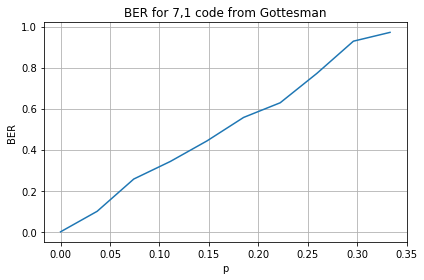

In [29]:
plt.plot(probab_list, ber_list)
plt.ylabel('BER')
plt.xlabel('p')
plt.title('BER' + ' for ' + str(n) + ',' + str(k) + ' code from Gottesman')
plt.grid()
plt.tight_layout()

# saveName = './plots/1' + errSaveName + '_' + str(n) + ',' + str(k) + '_iter_' + str(tot_iter) + '_totp_' + str(tot_probabs) + '.png'
plt.show()
# plt.savefig(saveName)
# print(saveName)

In [ ]:
plt.plot(probab_list, myError_list)
plt.ylabel(errString)
plt.xlabel('p')
plt.title(errString + ' for ' + str(n) + ',' + str(k) + ' code from Gottesman')
plt.grid()
plt.tight_layout()

saveName = './plots/1' + errSaveName + '_' + str(n) + ',' + str(k) + '_iter_' + str(tot_iter) + '_totp_' + str(tot_probabs) + '.png'
# plt.show()
# plt.savefig(saveName)
print(saveName)

### TODO
- Implement minimum fidelity
- Generate plots for other codes


- Check how decoding is done in Gottesman (to fix the null-space problem)
- Maybe try implementing the circuits if there are any


- Maybe start generating data

## Rough